# KPI Analysis for Original Network

This notebook analyzes the **Original Network** scenario performance. Results are read from the **Original network/results** folder.

## Analysis Overview

This analysis provides:
1. **Bidirectional Flow Analysis**: Speed and waiting time comparison for both directions (E0->E5 and E5->E0)
2. **Vehicle Performance**: Comparison between buses and transversal traffic
3. **KPI Summary**: Key performance indicators for different vehicle categories

# Original Network Simulation & Analysis

This notebook runs the **original network** scenario (uncontrolled baseline) and analyzes its KPIs. Results are written to the **Original network/results** folder.

## Simulation & Analysis Overview

1. **SUMO Simulation**: Runs an uncontrolled traffic scenario with default traffic lights
2. **Data Collection**: Collects tripinfo and edge data from the simulation
3. **KPI Analysis**: Analyzes the results with comprehensive visualizations


In [1]:
import os
import sys
import subprocess

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Original network")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")
CONFIG_PATH = os.path.join(SCENARIO_DIR, "ff_heterogeneous.sumocfg")

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

if not os.path.exists(CONFIG_PATH):
    sys.exit(f"Config file not found: {CONFIG_PATH}")

# SUMO tools
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

from sumolib import checkBinary

# Output files (will be created by config file settings)
TRIPINFO_PATH = os.path.join(RESULTS_DIR, "tripinfo.xml")
EDGE_DATA_PATH = os.path.join(RESULTS_DIR, "edge_data.xml")

# ==========================================
# 2. RUN SIMULATION (Direct SUMO execution)
# ==========================================
print("=" * 70)
print("RUNNING SUMO SIMULATION - ORIGINAL NETWORK")
print("=" * 70)

try:
    # Get SUMO binary (headless)
    sumoBinary = checkBinary('sumo')
    print(f"\n✓ SUMO binary: {sumoBinary}")
except:
    print("\n❌ ERROR: Could not find SUMO binary.")
    print("Please ensure SUMO is installed and SUMO_HOME is set correctly.")
    sys.exit(1)

# Build SUMO command (let config file handle outputs)
sumoCmd = [
    sumoBinary,
    "-c", CONFIG_PATH,
    "--no-warnings",
    "--no-step-log",
    "--time-to-teleport", "300"
]

print(f"\n📁 Scenario: {SCENARIO_DIR}")
print(f"📁 Results:  {RESULTS_DIR}")
print(f"\n🚀 Starting simulation...")
print("   This will take 1-3 minutes. Please wait...")

# Run SUMO directly as subprocess
try:
    # Change to scenario directory
    original_dir = os.getcwd()
    os.chdir(SCENARIO_DIR)
    
    # Run SUMO and capture output
    result = subprocess.run(
        sumoCmd,
        capture_output=True,
        text=True,
        timeout=300  # 5 minute timeout
    )
    
    # Return to original directory
    os.chdir(original_dir)
    
    # Check results
    if result.returncode == 0:
        print("\n✅ SIMULATION COMPLETED SUCCESSFULLY!")
        
        # Verify output files
        if os.path.exists(TRIPINFO_PATH) and os.path.exists(EDGE_DATA_PATH):
            trip_size = os.path.getsize(TRIPINFO_PATH) / 1024
            edge_size = os.path.getsize(EDGE_DATA_PATH) / 1024
            
            print(f"\n📊 Generated files:")
            print(f"   ✓ {os.path.basename(TRIPINFO_PATH)} ({trip_size:.1f} KB)")
            print(f"   ✓ {os.path.basename(EDGE_DATA_PATH)} ({edge_size:.1f} KB)")
            print("\n" + "=" * 70)
            print("✅ Ready to analyze! Continue to the next cells.")
            print("=" * 70)
        else:
            print("\n⚠️ WARNING: Simulation completed but output files not found!")
            print(f"   Expected: {TRIPINFO_PATH}")
            print(f"   Expected: {EDGE_DATA_PATH}")
    else:
        print(f"\n❌ SIMULATION FAILED (exit code: {result.returncode})")
        if result.stderr:
            print("\nError output:")
            print(result.stderr[:1000])
        
except subprocess.TimeoutExpired:
    os.chdir(original_dir)
    print("\n❌ SIMULATION TIMEOUT (5 minutes exceeded)")
    print("The simulation is taking too long. This may indicate a configuration issue.")
    
except Exception as e:
    os.chdir(original_dir)
    print(f"\n❌ ERROR: {e}")
    import traceback
    traceback.print_exc()


RUNNING SUMO SIMULATION - ORIGINAL NETWORK

✓ SUMO binary: C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe

📁 Scenario: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network
📁 Results:  c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results

🚀 Starting simulation...
   This will take 1-3 minutes. Please wait...

✅ SIMULATION COMPLETED SUCCESSFULLY!

📊 Generated files:
   ✓ tripinfo.xml (2958.5 KB)
   ✓ edge_data.xml (30.9 KB)

✅ Ready to analyze! Continue to the next cells.


In [2]:
# ==========================================
# 3. DATA LOADING SETUP
# ==========================================
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 4. CONFIGURATION FOR ANALYSIS
# ==========================================
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Original network")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")

# Definition of the two directions
DIR_A_EDGES = ["E0E1", "E1E2", "E2E3", "E3E4", "E4E5"]  # Forward (E0 -> E5)
DIR_B_EDGES = ["E5E4", "E4E3", "E3E2", "E2E1", "E1E0"]  # Backward (E5 -> E0)

# Network Analysis

This section analyzes the network structure and traffic light systems.

In [3]:
from collections import Counter

def analyze_network_and_tls(path):
    """
    Analyzes basic network properties and Traffic Light Systems (TLS).
    """
    print(f"\n## Network & Traffic Light Analysis")
    if not os.path.exists(path):
        print(f"❌ ERROR: Network file not found: {path}")
        return

    tree = ET.parse(path)
    root = tree.getroot()
    
    edges = root.findall('edge')
    nodes = root.findall('junction')
    tls = [n for n in nodes if n.get('type') == 'traffic_light']
    
    print(f"✅ Network Summary:")
    print(f"   - Edges: {len(edges)}")
    print(f"   - Nodes: {len(nodes)} (Traffic Lights: {len(tls)})")
    
    return len(edges), len(nodes), len(tls)

# Run network analysis
net_path = os.path.join(SCENARIO_DIR, "ff.net.xml")
analyze_network_and_tls(net_path)


## Network & Traffic Light Analysis
✅ Network Summary:
   - Edges: 400
   - Nodes: 112 (Traffic Lights: 16)


(400, 112, 16)

# Demand Analysis

This section analyzes the demand profiles and multimodal flow.

In [4]:
def analyze_demand_details(path):
    """Analyzes demand profiles and multimodal flow (without temporal plot)."""
    print(f"\n## Demand Profiles & Multimodal Flow")
    
    if not os.path.exists(path):
        print(f"❌ ERROR: File not found: {path}")
        return

    tree = ET.parse(path)
    root = tree.getroot()
    
    vehicle_data = []
    stats_tags = Counter()

    def extract_data(elem, tag_type):
        stats_tags[tag_type] += 1
        
        # Vehicle Type
        v_type = elem.get('type', 'default')
        
        # Destination
        dest = "N/A"
        route = elem.find('route')
        if route is not None and route.get('edges'):
            dest = route.get('edges').split()[-1]
        elif elem.get('edges'):
            dest = elem.get('edges').split()[-1]
        elif elem.get('to'):
            dest = elem.get('to')
            
        vehicle_data.append({'type': v_type, 'dest': dest})

    # Search for ALL traffic definition types
    for tag in ['vehicle', 'trip', 'flow']:
        for item in root.findall(tag):
            extract_data(item, tag)

    print(f"📊 Found {sum(stats_tags.values())} total elements.")
    print(f"   Breakdown: {dict(stats_tags)}")

    # Fleet and direction statistics
    print(f"\n- **Fleet Analysis:**")
    counts = Counter([v['type'] for v in vehicle_data])
    for v_type, num in counts.items():
        dests = [v['dest'] for v in vehicle_data if v['type'] == v_type and v['dest'] != "N/A"]
        if dests:
            main_dest = Counter(dests).most_common(1)[0][0]
            print(f"   - **{v_type}**: {num} units (Primary Destination: {main_dest})")
        else:
            print(f"   - **{v_type}**: {num} units (Destinations not deducible)")

# Run demand analysis
route_path = os.path.join(SCENARIO_DIR, "ff_heterogeneous.rou.xml")
analyze_demand_details(route_path)


## Demand Profiles & Multimodal Flow
📊 Found 80648 total elements.
   Breakdown: {'flow': 80648}

- **Fleet Analysis:**
   - **DEFAULT_BIKETYPE**: 4 units (Primary Destination: D1D0)
   - **t_0**: 4 units (Primary Destination: C1C0)
   - **car**: 80640 units (Primary Destination: D1D0)


# Traffic Demand Visualization

This section visualizes the lane-based traffic demand across the network.

⏳ Loading route data and counting edge demand...
✅ Data extracted: 80 active edges processed.
🗺️ Rendering network map with lane division...
Saved: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results\lane_network_demand.png


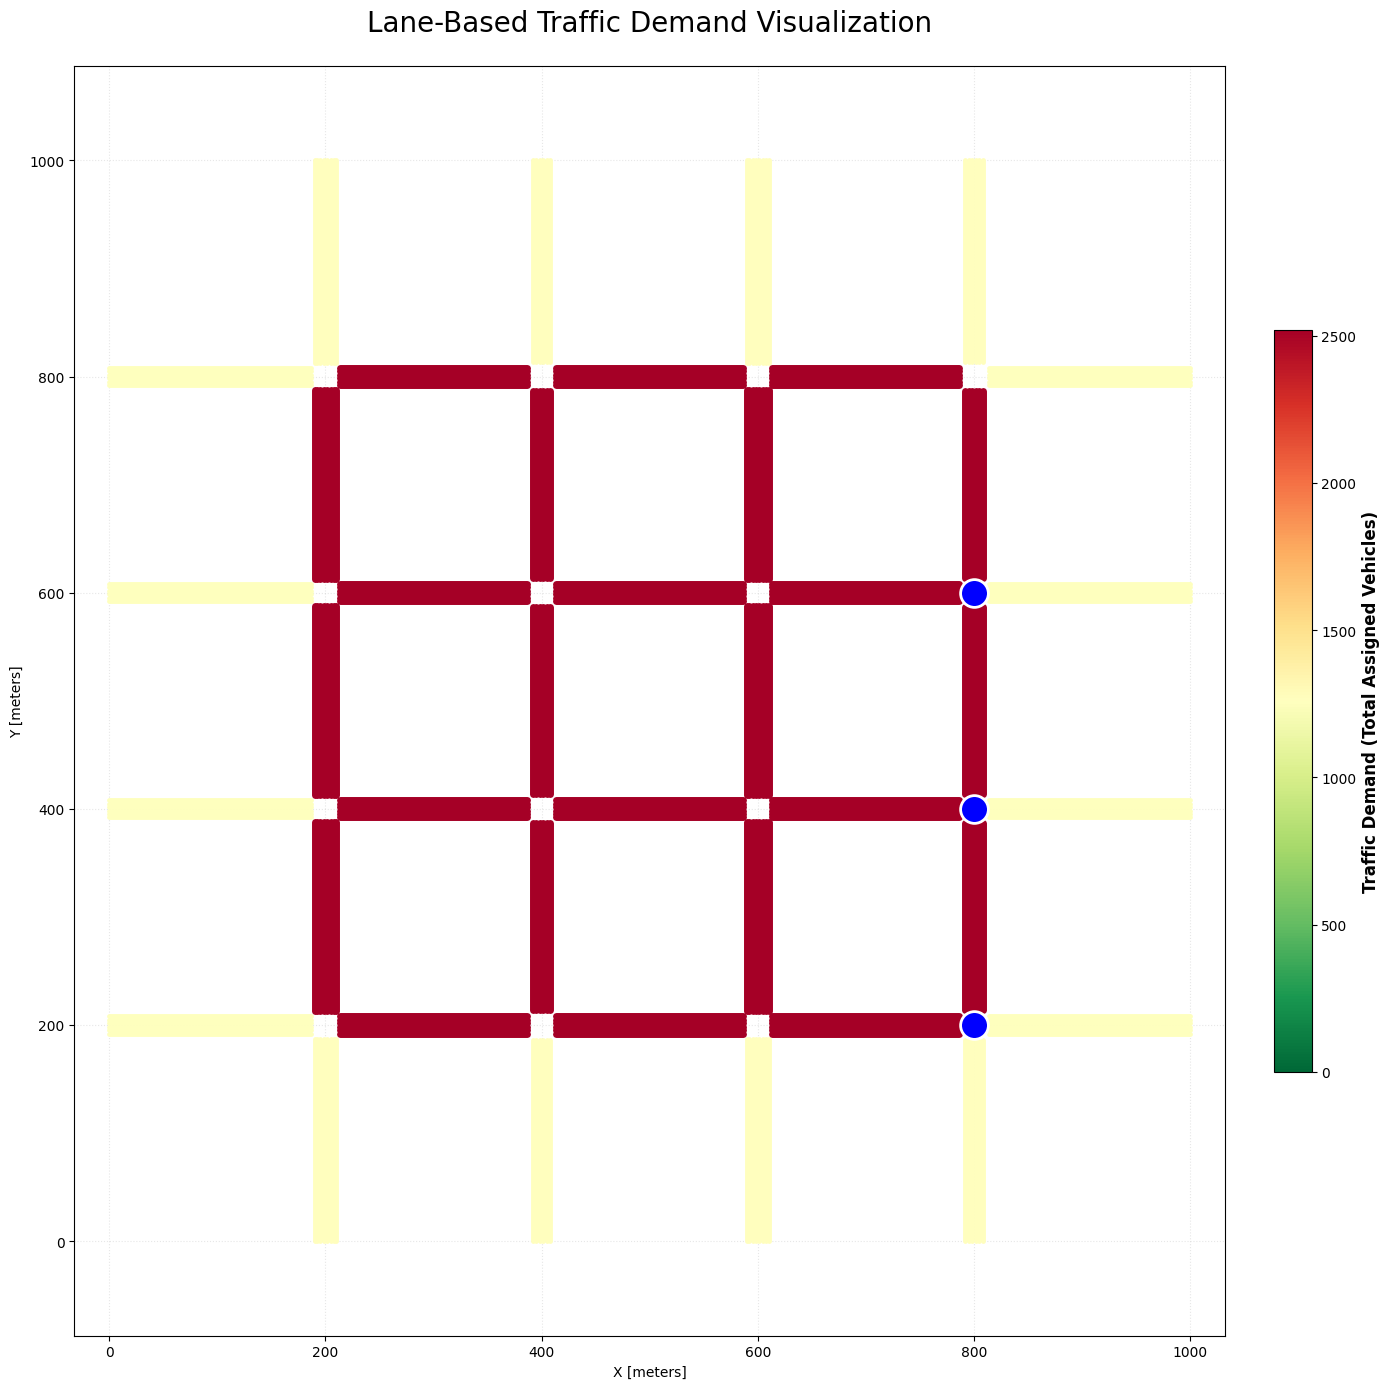

In [5]:
import sumolib
import matplotlib.colors as mcolors
from pathlib import Path

def plot_lane_network_load_map(net_file, route_file):
    """Plot lane-based traffic demand visualization."""
    print("⏳ Loading route data and counting edge demand...")
    
    if not os.path.exists(route_file):
        print(f"❌ ERROR: Route file {route_file} not found.")
        return

    # 1. ROUTE PARSING
    tree = ET.parse(route_file)
    root = tree.getroot()
    edge_counts = {}

    def process_edges(edge_string):
        if not edge_string: return
        edges = edge_string.split()
        for e in edges:
            edge_counts[e] = edge_counts.get(e, 0) + 1

    for tag in ['vehicle', 'flow', 'trip']:
        for item in root.findall(tag):
            route_tag = item.find('route')
            if route_tag is not None and route_tag.get('edges'):
                process_edges(route_tag.get('edges'))
            elif item.get('edges'):
                process_edges(item.get('edges'))
            elif item.get('from') and item.get('to'):
                edge_counts[item.get('from')] = edge_counts.get(item.get('from'), 0) + 1
                edge_counts[item.get('to')] = edge_counts.get(item.get('to'), 0) + 1

    print(f"✅ Data extracted: {len(edge_counts)} active edges processed.")

    # 2. SPATIAL MAP GENERATION
    print("🗺️ Rendering network map with lane division...")
    
    # Load Network with URI fix for Windows compatibility
    net = sumolib.net.readNet(Path(net_file).resolve().as_uri())
    
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.set_facecolor('white')
    
    if edge_counts:
        max_load = max(edge_counts.values())
        norm = mcolors.Normalize(vmin=0, vmax=max_load)
        cmap = plt.get_cmap('RdYlGn_r') 
    else:
        print("⚠️ No demand data found to color the map.")
        return

    # 3. LANE-BY-LANE RENDERING
    for edge in net.getEdges():
        eid = edge.getID()
        if eid.startswith(':'): continue 
            
        count = edge_counts.get(eid, 0)
        
        if count > 0:
            color = cmap(norm(count))
            lw = 2.0 + (count / max_load) * 3 
            z = 10
        else:
            color = '#f0f0f0'
            lw = 1.0
            z = 1
            
        for lane in edge.getLanes():
            shape = lane.getShape()
            xs, ys = zip(*shape)
            ax.plot(xs, ys, color=color, linewidth=lw, zorder=z, solid_capstyle='round')

    # 4. COLORBAR
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Traffic Demand (Total Assigned Vehicles)', fontsize=12, fontweight='bold')

    # 5. HIGHLIGHT NODES E1, E2, E3
    for node_id in ['E1', 'E2', 'E3']:
        node = net.getNode(node_id)
        if node:
            x, y = node.getCoord()
            ax.scatter(x, y, s=400, c='blue', marker='o', zorder=50, edgecolors='white', linewidth=2)
            ax.text(x, y+25, node_id, color='blue', fontsize=14, fontweight='black', 
                    ha='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.title("Lane-Based Traffic Demand Visualization", fontsize=20, pad=25)
    plt.xlabel("X [meters]", fontsize=10)
    plt.ylabel("Y [meters]", fontsize=10)
    plt.axis('equal')
    plt.grid(True, linestyle=':', alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(RESULTS_DIR, "lane_network_demand.png")
    plt.savefig(plot_path, dpi=300)
    print(f"Saved: {plot_path}")
    plt.show()

# Run visualization
net_path = os.path.join(SCENARIO_DIR, "ff.net.xml")
route_path = os.path.join(SCENARIO_DIR, "ff_heterogeneous.rou.xml")
if os.path.exists(net_path) and os.path.exists(route_path):
    plot_lane_network_load_map(net_path, route_path)
else:
    print("❌ Error: One or more files are missing. Check your paths.")

# Network Performance & Congestion Map

This section visualizes network performance with speed and congestion indicators.

⏳ Generating Green-Red map with large labels...
🗺️ Rendering links and speeds...
Saved: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results\network_congestion_map.png


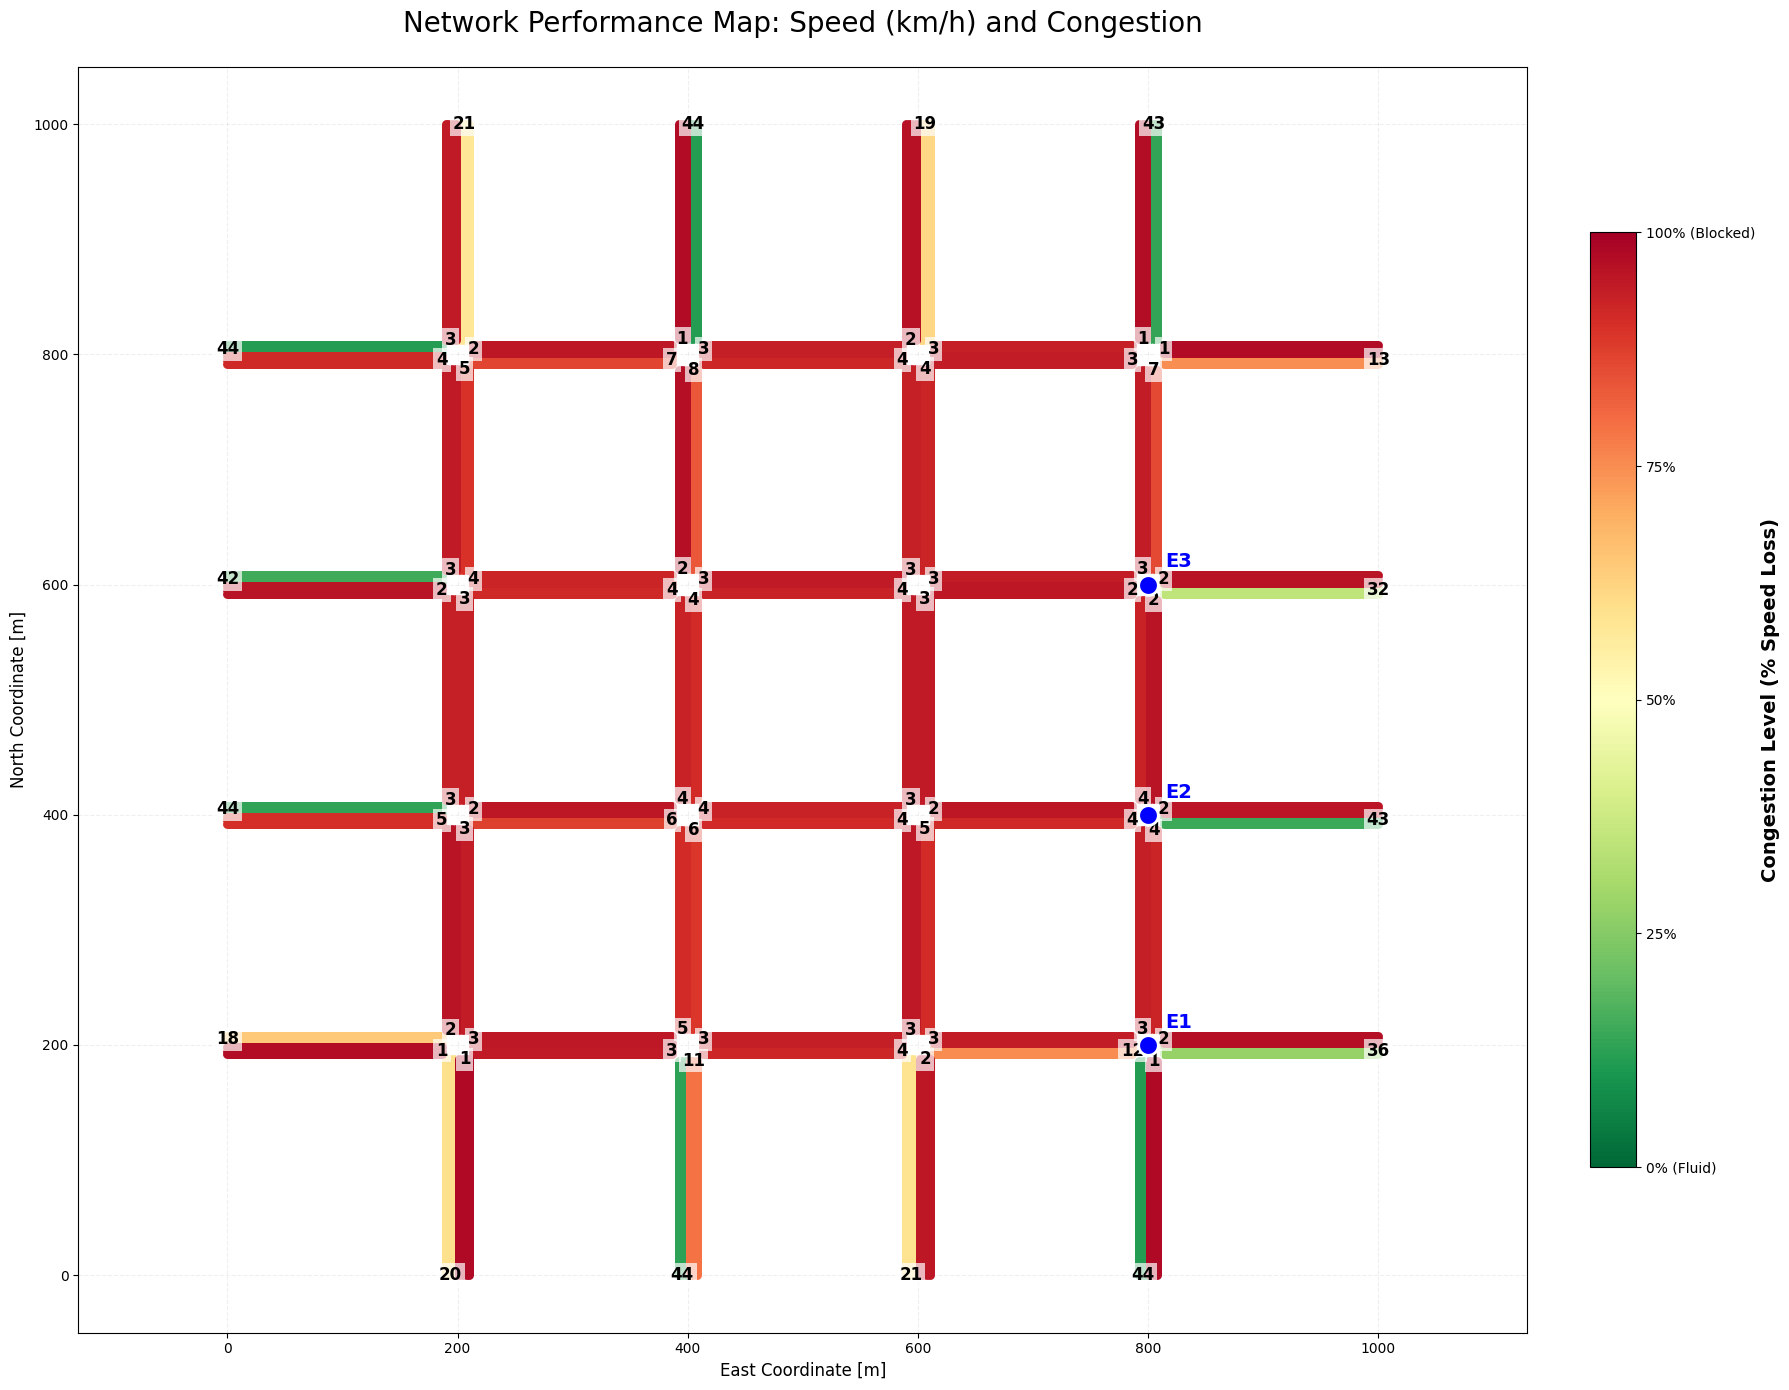

In [6]:
def plot_congestion_heatmap(net_file, data_file):
    """Generate network performance map with speed and congestion indicators."""
    print("⏳ Generating Green-Red map with large labels...")
    
    if not os.path.exists(data_file):
        print(f"❌ ERROR: File {data_file} does not exist.")
        return

    # 1. Network Loading (Windows URI Fix)
    net = sumolib.net.readNet(Path(net_file).resolve().as_uri())
    
    # 2. Result Parsing
    edge_speeds = {}
    tree = ET.parse(data_file)
    root = tree.getroot()
    
    for interval in root.findall('interval'):
        for edge in interval.findall('edge'):
            eid = edge.get('id')
            try:
                speed = float(edge.get('speed'))
                if eid not in edge_speeds:
                    edge_speeds[eid] = []
                edge_speeds[eid].append(speed)
            except (ValueError, TypeError):
                pass

    # 3. Plot Preparation
    fig, ax = plt.subplots(figsize=(18, 14))
    ax.set_facecolor('white')
    
    cmap = plt.get_cmap('RdYlGn_r')
    
    print("🗺️ Rendering links and speeds...")
    for edge in net.getEdges():
        eid = edge.getID()
        avg_speed_ms = sum(edge_speeds[eid]) / len(edge_speeds[eid]) if eid in edge_speeds else None
        speed_limit = edge.getSpeed()
        
        # Congestion Calculation (0.0 = Fluid/Green, 1.0 = Blocked/Red)
        congestion = 0.0
        if avg_speed_ms is not None and speed_limit > 0.1:
            congestion = max(0.0, min(1.0, 1.0 - (avg_speed_ms / speed_limit)))

        # 4. Drawing Lanes
        for lane in edge.getLanes():
            shape = lane.getShape()
            xs, ys = zip(*shape)
            
            if avg_speed_ms is not None:
                color = cmap(congestion)
                lw = 3.0 + (speed_limit / 4.0)
                z = 10 + (congestion * 50)
            else:
                color = '#f0f0f0'
                lw = 1.0
                z = 1
            
            ax.plot(xs, ys, color=color, linewidth=lw, zorder=z, solid_capstyle='round')

        # 5. Large Speed Labels at the center of the Link
        if avg_speed_ms is not None:
            avg_speed_kmh = avg_speed_ms * 3.6
            shape = edge.getShape()
            
            mid_idx = len(shape) // 2
            mid_x, mid_y = shape[mid_idx]
            
            ax.text(mid_x, mid_y, f"{avg_speed_kmh:.0f}", 
                    color='black', fontsize=12, fontweight='bold',
                    ha='center', va='center', zorder=150,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))

    # 6. Graduated Scale (Colorbar)
    norm = mcolors.Normalize(vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Congestion Level (% Speed Loss)', fontsize=14, fontweight='bold')
    
    tick_locs = [0, 25, 50, 75, 100]
    cbar.set_ticks(tick_locs)
    cbar.ax.set_yticklabels(['0% (Fluid)', '25%', '50%', '75%', '100% (Blocked)'])

    # 7. Highlight Target nodes
    for node_id in ['E1', 'E2', 'E3']:
        node = net.getNode(node_id)
        if node:
            x, y = node.getCoord()
            ax.scatter(x, y, s=200, c='blue', marker='o', zorder=200, edgecolors='white', linewidth=2)
            ax.text(x+15, y+15, node_id, color='blue', fontsize=14, fontweight='bold', zorder=201)

    plt.title("Network Performance Map: Speed (km/h) and Congestion", fontsize=20, pad=25)
    plt.xlabel("East Coordinate [m]", fontsize=12)
    plt.ylabel("North Coordinate [m]", fontsize=12)
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(RESULTS_DIR, "network_congestion_map.png")
    plt.savefig(plot_path, dpi=300)
    print(f"Saved: {plot_path}")
    plt.show()

# Run congestion heatmap
edge_data_path = os.path.join(RESULTS_DIR, "edge_data.xml")
if os.path.exists(net_path) and os.path.exists(edge_data_path):
    plot_congestion_heatmap(net_path, edge_data_path)
else:
    print("❌ Error: One or more files are missing. Check your paths.")

In [7]:
# ==========================================
# 5. VEHICLE CLASSIFICATION
# ==========================================
def classify_vehicle(veh_id):
    """Classify vehicles based on their ID prefix."""
    prefix = veh_id.split('.')[0] if '.' in veh_id else veh_id
    
    # --- Direction A (E0 -> E5) ---
    if prefix in ['f_7']: 
        return "Bus Dir A (E0->E5)", "Bus", "Dir A"
    
    # --- Direction B (E5 -> E0) ---
    elif prefix in ['f_6']: 
        return "Bus Dir B (E5->E0)", "Bus", "Dir B"
        
    # --- Other categories ---
    elif prefix in ['f_4', 'f_5']:
        return "Other Bus", "Bus", "Other"
    elif prefix in ['f_0', 'f_1', 'f_2', 'f_3']:
        return "Transversal Traffic", "Traffic", "Transversal"
    else:
        return "Background", "Car", "Other"

In [8]:
# ==========================================
# 5. DATA LOADING
# ==========================================
def load_data(data_folder):
    """Load trip and edge data from XML files."""
    trip_path = os.path.join(data_folder, "tripinfo.xml")
    edge_path = os.path.join(data_folder, "edge_data.xml")

    # --- 1. TRIPINFO (Individual vehicles) ---
    trips = []
    if os.path.exists(trip_path):
        tree = ET.parse(trip_path)
        for t in tree.getroot().findall('tripinfo'):
            cat, vtype, route_group = classify_vehicle(t.get('id'))
            
            duration = float(t.get('duration'))
            route_len = float(t.get('routeLength', 0))
            
            # Calculate average trip speed in km/h
            speed_kmh = (route_len / duration) * 3.6 if duration > 0 else 0

            trips.append({
                'id': t.get('id'),
                'category': cat,
                'type': vtype,
                'route_group': route_group,
                'waitingTime': float(t.get('waitingTime')),
                'duration': duration,
                'routeLength': route_len,
                'speed_kmh': speed_kmh
            })
    df_trips = pd.DataFrame(trips)

    # --- 2. EDGE DATA (Roads) ---
    edges_stats = []
    if os.path.exists(edge_path):
        tree = ET.parse(edge_path)
        intervals = tree.getroot().findall('interval')
        if intervals:
            # Use the last interval
            for e in intervals[-1].findall('edge'):
                eid = e.get('id')
                direction = "None"
                order = 99
                
                if eid in DIR_A_EDGES:
                    direction = "Dir A (E0->E5)"
                    order = DIR_A_EDGES.index(eid)
                elif eid in DIR_B_EDGES:
                    direction = "Dir B (E5->E0)"
                    order = DIR_B_EDGES.index(eid)
                
                if direction != "None":
                    speed_ms = float(e.get('speed', 0))
                    wait_sec = float(e.get('waitingTime', 0)) 
                    
                    edges_stats.append({
                        'edge_id': eid,
                        'direction': direction,
                        'order': order,
                        'speed_kmh': speed_ms * 3.6,        # m/s -> km/h
                        'waiting_hours': wait_sec / 3600.0, # seconds -> hours
                        'density': float(e.get('density', 0))
                    })
    
    df_edges = pd.DataFrame(edges_stats)
    if not df_edges.empty:
        df_edges = df_edges.sort_values(by=['direction', 'order'])

    return df_trips, df_edges

In [9]:
# ==========================================
# 6. VISUALIZATION
# ==========================================
def create_dashboard(df_trips, df_edges, output_dir):
    """Create comprehensive KPI dashboards."""
    sns.set_theme(style="whitegrid")
    
    # Separate edge datasets by direction
    df_edges_A = df_edges[df_edges['direction'] == "Dir A (E0->E5)"]
    df_edges_B = df_edges[df_edges['direction'] == "Dir B (E5->E0)"]

    # --- FIGURE 1: EDGE ANALYSIS (SPEED & WAIT) ---
    fig1, axes = plt.subplots(3, 2, figsize=(16, 12), constrained_layout=True)
    fig1.suptitle("Edge Analysis: Bidirectional Flow (km/h & Hours)", fontsize=18, fontweight='bold')

    # Column titles
    axes[0,0].set_title("DIRECTION A (E0 -> E5)", fontsize=14, color='green', fontweight='bold')
    axes[0,1].set_title("DIRECTION B (E5 -> E0)", fontsize=14, color='blue', fontweight='bold')

    # ROW 1: SPEED (km/h)
    if not df_edges_A.empty:
        sns.lineplot(data=df_edges_A, x='edge_id', y='speed_kmh', marker='o', color='green', ax=axes[0,0], linewidth=3)
        axes[0,0].set_ylabel("Speed (km/h)")
        for x, y in zip(range(len(df_edges_A)), df_edges_A['speed_kmh']):
            axes[0,0].text(x, y+0.5, f"{y:.1f}", ha='center', color='green', fontweight='bold')
            
    if not df_edges_B.empty:
        sns.lineplot(data=df_edges_B, x='edge_id', y='speed_kmh', marker='o', color='blue', ax=axes[0,1], linewidth=3)
        axes[0,1].set_ylabel("")
        for x, y in zip(range(len(df_edges_B)), df_edges_B['speed_kmh']):
            axes[0,1].text(x, y+0.5, f"{y:.1f}", ha='center', color='blue', fontweight='bold')

    # ROW 2: TOTAL ACCUMULATED WAITING TIME (Hours)
    if not df_edges_A.empty:
        sns.barplot(data=df_edges_A, x='edge_id', y='waiting_hours', hue='edge_id', palette="Greens", ax=axes[1,0], legend=False, edgecolor='black')
        axes[1,0].set_ylabel("Total Accumulated Wait (Hours)")
        
    if not df_edges_B.empty:
        sns.barplot(data=df_edges_B, x='edge_id', y='waiting_hours', hue='edge_id', palette="Blues", ax=axes[1,1], legend=False, edgecolor='black')
        axes[1,1].set_ylabel("")

    # ROW 3: HEATMAPS (Hours)
    if not df_edges_A.empty:
        matrix_A = df_edges_A[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_A, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,0], cbar=False)
        axes[2,0].set_xlabel("Edge Sequence")
        
    if not df_edges_B.empty:
        matrix_B = df_edges_B[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_B, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,1], cbar_kws={'label': 'Hours'})
        axes[2,1].set_xlabel("Edge Sequence")

    plot_path_1 = os.path.join(output_dir, "edge_analysis_bidirectional.png")
    plt.savefig(plot_path_1, dpi=300)
    print(f"Saved: {plot_path_1}")

    # --- FIGURE 2: BUS vs NETWORK COMPARISON ---
    fig2, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    fig2.suptitle("Strategic KPI: Bus Performance Analysis", fontsize=16, fontweight='bold')

    # 1. Waiting Time Comparison
    target_buses = df_trips[df_trips['type'] == 'Bus']
    if not target_buses.empty:
        sns.barplot(data=target_buses, x='category', y='waitingTime', hue='category', palette="viridis", ax=axes[0,0], legend=False)
        axes[0,0].set_title("Avg Bus Trip Waiting Time (Seconds)", fontweight='bold')
        axes[0,0].set_ylabel("Seconds per Trip")
        for c in axes[0,0].containers:
            axes[0,0].bar_label(c, fmt='%.1f', padding=3)

    # 2. Speed Comparison
    comp_groups = ["Bus Dir A (E0->E5)", "Bus Dir B (E5->E0)", "Transversal Traffic"]
    speed_df = df_trips[df_trips['category'].isin(comp_groups)]
    
    if not speed_df.empty:
        sns.boxplot(data=speed_df, x='category', y='speed_kmh', hue='category', palette="Set2", ax=axes[0,1], legend=False)
        axes[0,1].set_title("Speed Comparison: Bus vs Cross Traffic", fontweight='bold')
        axes[0,1].set_ylabel("Mean Trip Speed (km/h)")

    # 3. Duration Breakdown - Bottom Left
    dur_df = df_trips.groupby('category')['duration'].mean().reset_index()
    dur_df = dur_df[dur_df['category'].isin(comp_groups + ["Other Bus"])]
    
    if not dur_df.empty:
        sns.barplot(data=dur_df, x='category', y='duration', hue='category', palette="coolwarm", ax=axes[1,0], legend=False)
        axes[1,0].set_title("Average Trip Duration", fontweight='bold')
        axes[1,0].set_ylabel("Duration (seconds)")
        for c in axes[1,0].containers:
            axes[1,0].bar_label(c, fmt='%.1f', padding=3)

    # 4. Text Summary Box - Bottom Right
    axes[1,1].axis('off')
    
    text_str = "KPI SUMMARY REPORT\n" + "="*35 + "\n"
    
    # Global network summary
    text_str += "GLOBAL NETWORK SUMMARY:\n"
    text_str += f"  - Total Vehicles: {len(df_trips)}\n"
    text_str += f"  - Avg Waiting:    {df_trips['waitingTime'].mean():.2f} s\n"
    text_str += f"  - Avg Speed:      {df_trips['speed_kmh'].mean():.2f} km/h\n"
    text_str += "-"*35 + "\n"

    # Category breakdown
    for cat in comp_groups:
        subset = df_trips[df_trips['category'] == cat]
        if not subset.empty:
            avg_wait = subset['waitingTime'].mean()
            avg_speed = subset['speed_kmh'].mean()
            avg_duration = subset['duration'].mean()
            count = len(subset)
            text_str += f"{cat}:\n"
            text_str += f"  - Vehicles:  {count}\n"
            text_str += f"  - Avg Speed: {avg_speed:.2f} km/h\n"
            text_str += f"  - Avg Wait:  {avg_wait:.2f} s\n"
            text_str += f"  - Avg Dur:   {avg_duration:.2f} s\n\n"
    
    axes[1,1].text(0.05, 0.95, text_str, fontsize=10, fontfamily='monospace', verticalalignment='top', 
                   bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

    plot_path_2 = os.path.join(output_dir, "kpi_analysis_performance.png")
    plt.savefig(plot_path_2, dpi=300)
    print(f"Saved: {plot_path_2}")
    plt.show()

## KPI Analysis Results

This section loads and visualizes the performance data from the Original Network scenario.

Reading data from: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results
Saving plots to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results

Loaded 7315 trips and 10 edge records
Saved: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results\edge_analysis_bidirectional.png
Saved: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results\kpi_analysis_performance.png


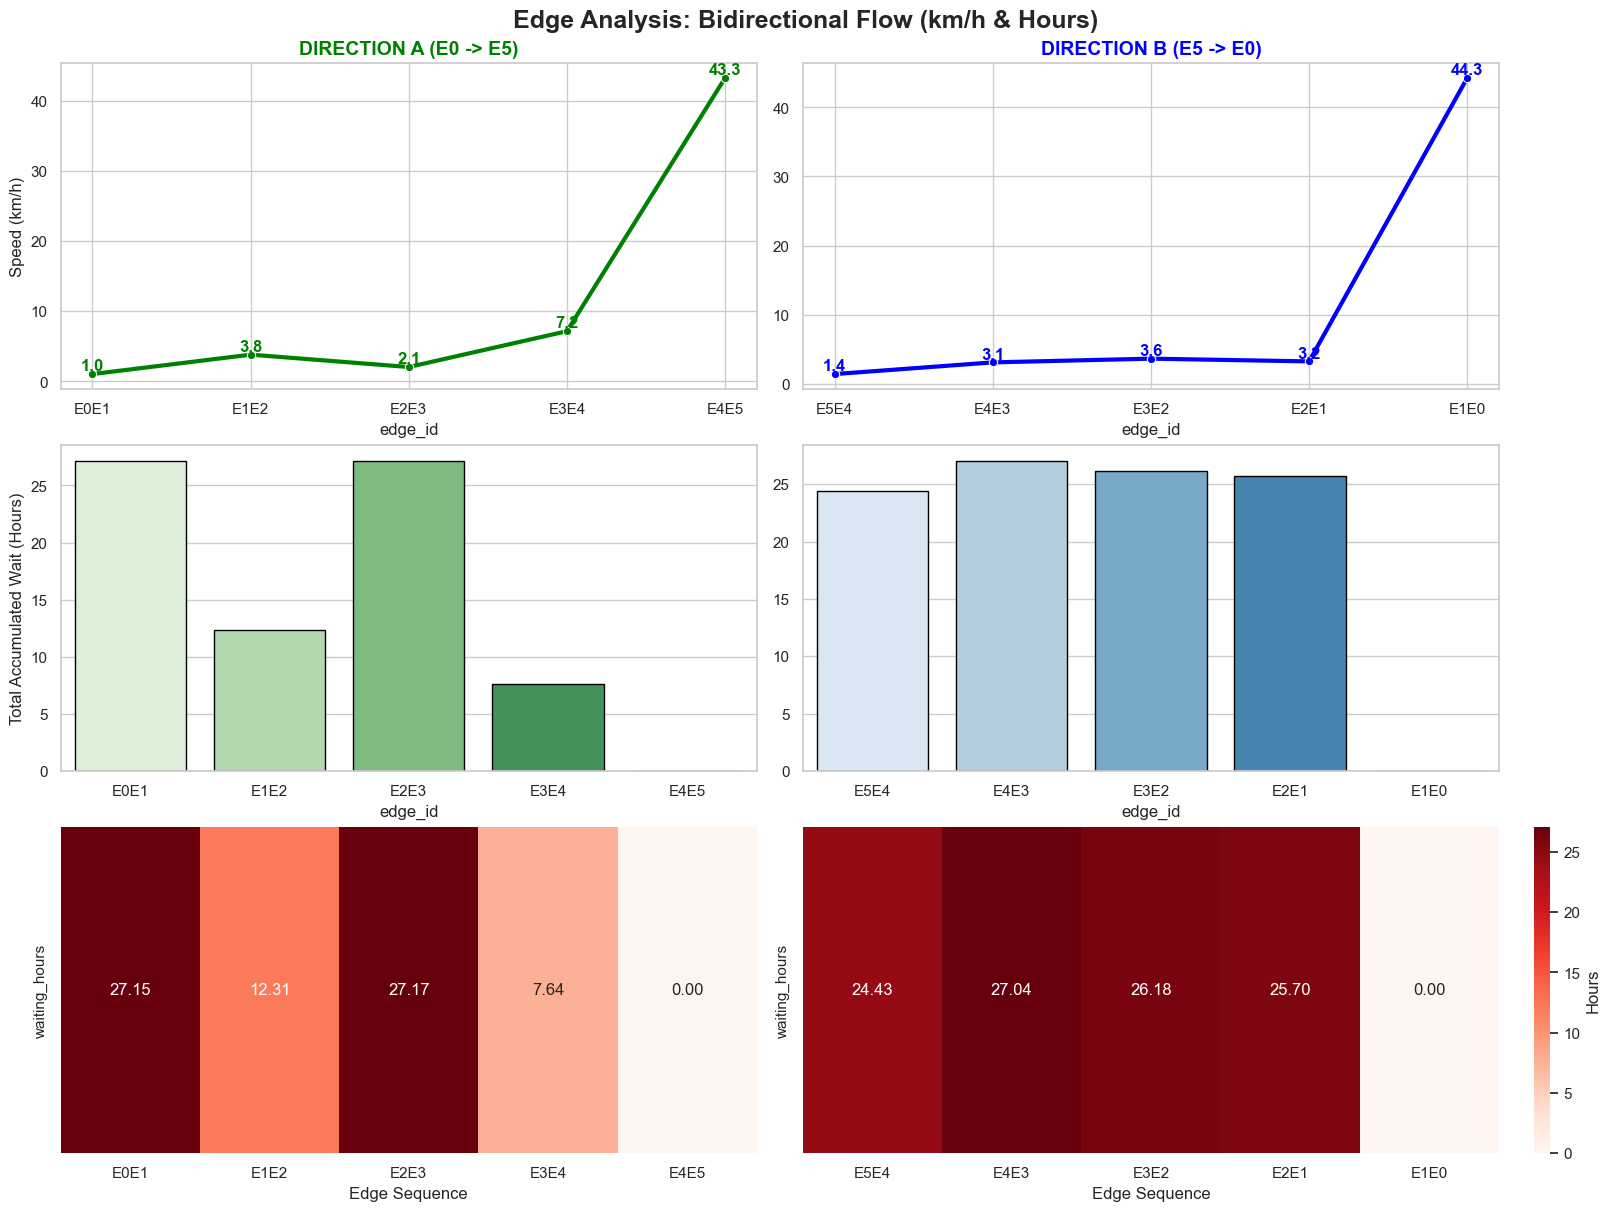

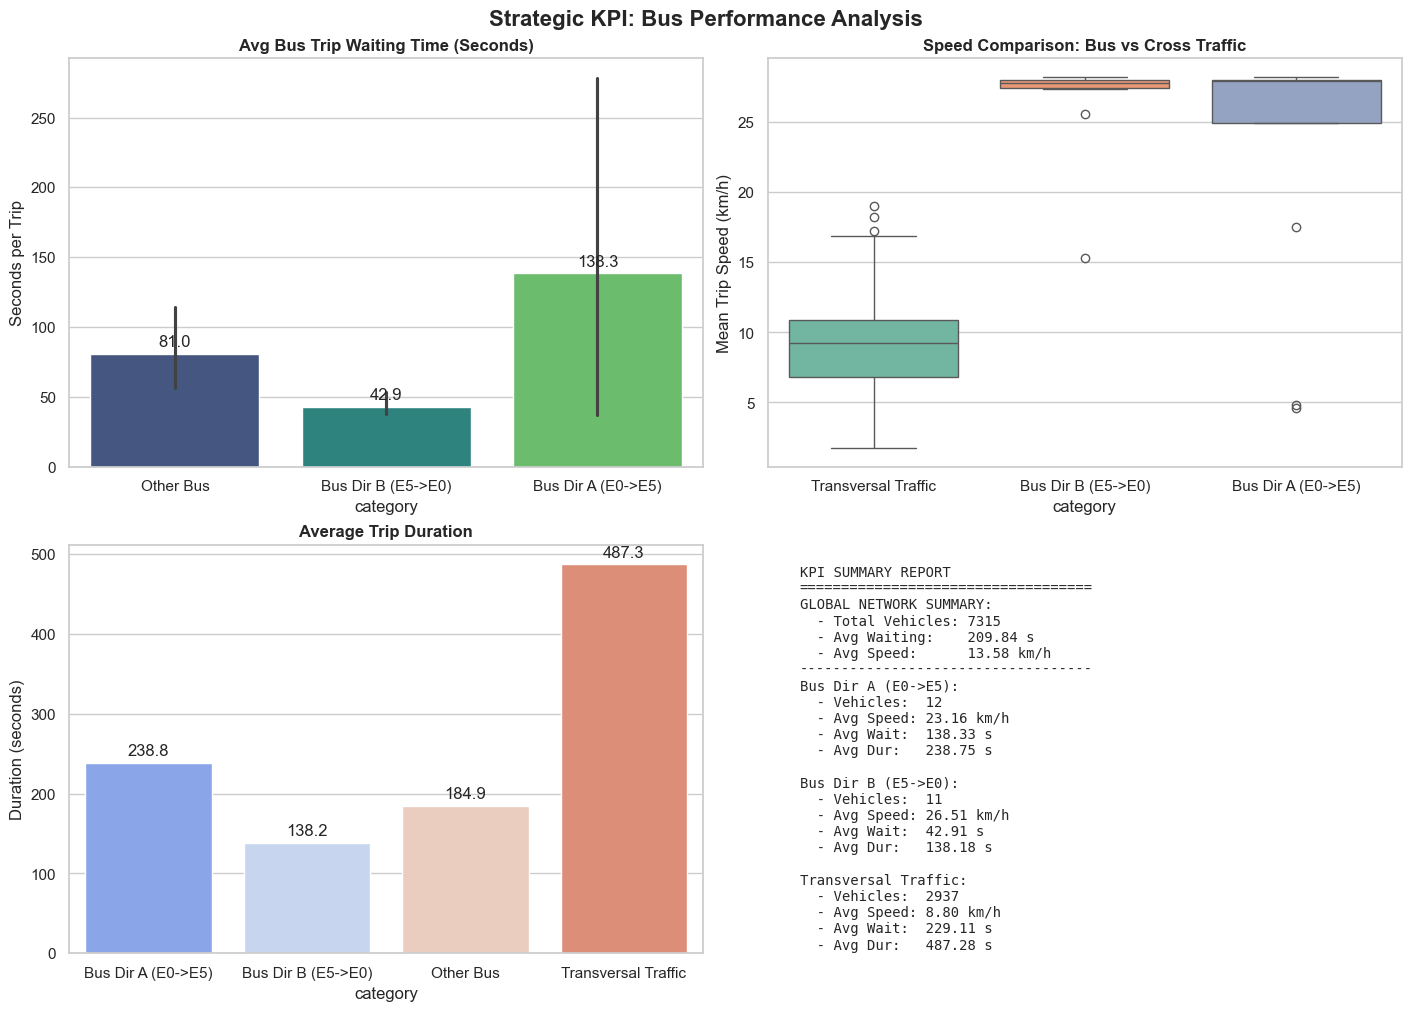


Analysis completed successfully!


In [10]:
# ==========================================
# 7. EXECUTION
# ==========================================
print(f"Reading data from: {RESULTS_DIR}")
print(f"Saving plots to: {RESULTS_DIR}")

try:
    trips, edges = load_data(RESULTS_DIR)
    
    if trips.empty:
        print("\nWARNING: No trip data found.")
        print("Please ensure the simulation has been run.")
        print(f"Expected file: {os.path.join(RESULTS_DIR, 'tripinfo.xml')}")
    else:
        print(f"\nLoaded {len(trips)} trips and {len(edges)} edge records")
        create_dashboard(trips, edges, RESULTS_DIR)
        print("\nAnalysis completed successfully!")
        
except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()